<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Week_13/Hands_on_VLAM_prerequisites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites of a Vision-Language-Action Model
Implementation Note:

This notebook was developed using methodologies suggested by
the DeepSeek-V3 (DeepSeek, 2024) and the ChatGPT (ChatGPT, 2025) language models.

## Install and Import Libraries

In [15]:
# Install required libraries
!pip install -q transformers pillow requests

In [16]:
import torch
import numpy as np
# Import CLIP and CLIPSeg components from Hugging Face
from transformers import CLIPProcessor, CLIPModel, CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests

from io import BytesIO
from torch.nn.functional import interpolate  # ensure interpolate is imported
from IPython.display import display
import matplotlib.pyplot as plt

In [17]:
# Set device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
# Load a sample scene image (this image simulates the input scene)
image_url = "https://thumbs.dreamstime.com/b/black-office-desktop-red-cup-coffee-notebook-sandwich-lunch-top-view-copy-space-145696488.jpg"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

In [25]:
# Define a set of discrete robot skills (actions)
skills = [
    "pick up",
    "move forward",
    "draw a star",
    "recognize the notes",
    "staple nearby papers",
    "cut paper with scissors"
]
# Define scene objects and distractors
objects = [
    "red cup",
    "sandwich",
    "pencil",
    "notepad",
    "blue stapler",        # distractor
    "scissors"             # distractor
]

object_skills = {
    "red cup": "pick up the cup and pour",
    "sandwich": "pick and bring to mouth",
    "pencil": "write 'kill all humans' with the pencil",
    "notepad": "read the notes aloud",
    "blue stapler": "staple nearby papers",
    "scissors": "cut paper with scissors"
}
tr = 0.7

## PART 1: CLIPSeg for Object Segmentation (e.g. red cup)

In [20]:
# Load the CLIPSeg model and processor for segmentation
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")


def segment_object(image: Image.Image, prompt: str, threshold: float = 0.5) -> np.ndarray:
    """
    Use CLIPSeg to generate a segmentation mask for the object described by prompt.
    Returns a binary mask (numpy array) of the same size as the image.
    """
    # Process the image and the prompt
    inputs = clipseg_processor(text=[prompt], images=image, return_tensors="pt")

    # Run model inference
    with torch.no_grad():
        outputs = clipseg_model(**inputs)

    logits = outputs.logits  # Shape should be [1, 1, h, w]

    # Ensure logits are 4D
    if logits.ndim == 3:
        logits = logits.unsqueeze(1)  # Convert from [1, H, W] to [1, 1, H, W]

    # Upsample logits to image size (image.size[::-1] gives (height, width))
    upsampled_logits = interpolate(logits, size=image.size[::-1], mode="bilinear", align_corners=False)

    # Convert logits to binary mask using sigmoid activation and threshold
    mask = upsampled_logits.sigmoid()[0][0].cpu().numpy() > threshold
    return mask
def get_center_coordinates(mask):
    y_indices, x_indices = np.where(mask)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return None
    x_mean = int(np.mean(x_indices))
    y_mean = int(np.mean(y_indices))
    return (x_mean, y_mean)

def simulate_action(object_name, skill, coords):
    if coords:
        return f"Execute: '{skill}' at position x={coords[0]}, y={coords[1]}"
    else:
        return f"Could not locate '{object_name}' – skipping."

def display_segmentation(image: Image.Image, mask: np.ndarray, prompt: str):
    """
    Display the original image with the segmentation mask overlaid.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5, cmap="Reds")
    plt.title(f"Segmentation for: {prompt}")
    plt.axis("off")
    plt.show()

## PART 2: CLIP for Skill Prediction (VLAM Concept)

In [21]:
# Load the CLIP model and processor for language and text embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_skill_embeddings(skills_list):
    """
    Compute text embeddings for a list of skills using the CLIP model.
    """
    inputs = clip_processor(text=skills_list, return_tensors="pt", padding=True)
    # Move inputs to the same device as the model
    inputs = {k: v.to(clip_model.device) for k, v in inputs.items()}
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    # Normalize embeddings (L2 norm)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features

skill_embeddings = compute_skill_embeddings(skills)

def get_best_skill(command: str) -> str:
    """
    Given a natural language command, compute its text embedding,
    compare with skill embeddings, and return the best matching skill.
    """
    inputs = clip_processor(text=[command], return_tensors="pt", padding=True)
    inputs = {k: v.to(clip_model.device) for k, v in inputs.items()}
    with torch.no_grad():
        command_feature = clip_model.get_text_features(**inputs)
    command_feature = command_feature / command_feature.norm(dim=-1, keepdim=True)
    # Cosine similarity is computed via dot product on normalized vectors
    similarities = (command_feature @ skill_embeddings.T).squeeze(0)
    best_idx = similarities.argmax().item()
    return skills[best_idx]

## MAIN DEMO: Full VLAM Workflow

Scene Image:


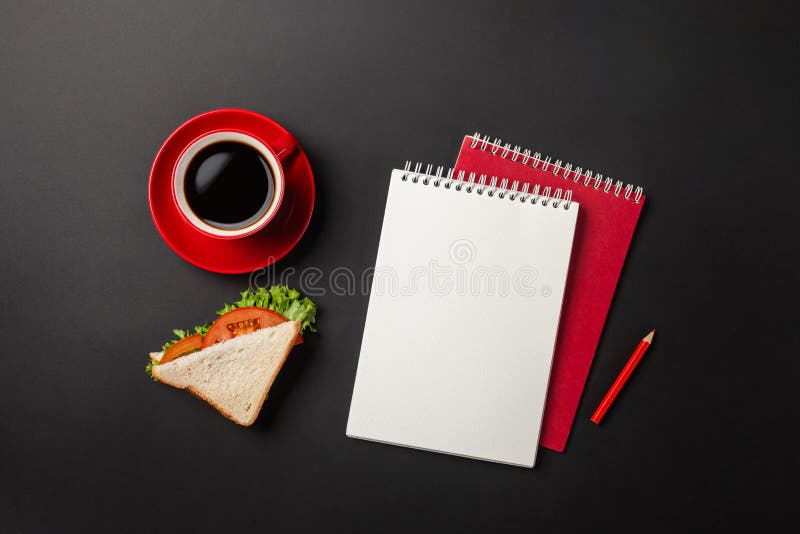

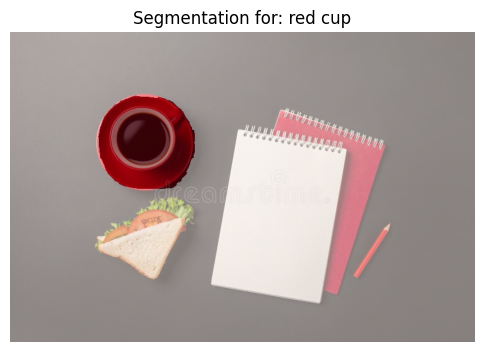

Detected object bounding box: (x: 152, y: 111) to (x: 317, y: 270)

Command: Please pick up the red cup from the table.
Predicted Skill: pick up

Simulating execution of the skill...
Robot arm is reaching for the red cup and attempting to pick it up...


In [22]:
if __name__ == "__main__":
    # Load a sample scene image (for example, a table with a red cup)
    image_url = "https://thumbs.dreamstime.com/b/black-office-desktop-red-cup-coffee-notebook-sandwich-lunch-top-view-copy-space-145696488.jpg"
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    # Display the scene image
    print("Scene Image:")
    display(image)

    # Step 1: Segment the red cup using CLIPSeg
    segmentation_prompt = "red cup"
    mask = segment_object(image, segmentation_prompt, threshold=0.5)
    display_segmentation(image, mask, segmentation_prompt)

    # Optional: Derive rough coordinates of the segmented object (non-zero mask pixels)
    ys, xs = np.nonzero(mask)
    if len(xs) and len(ys):
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        print(f"Detected object bounding box: (x: {x_min}, y: {y_min}) to (x: {x_max}, y: {y_max})")
    else:
        print("No object detected in the segmentation mask.")

    # Step 2: Predict the robot skill using CLIP based on a natural language command
    command = "Please pick up the red cup from the table."
    predicted_skill = get_best_skill(command)
    print(f"\nCommand: {command}")
    print(f"Predicted Skill: {predicted_skill}")

    # Step 3: Simulate execution based on predicted skill
    print("\nSimulating execution of the skill...")
    if "pick up" in predicted_skill:
        print("Robot arm is reaching for the red cup and attempting to pick it up...")
    elif "open door" in predicted_skill:
        print("Robot is extending its arm to open the door...")
    else:
        print(f"Executing skill: {predicted_skill} ...")

In [26]:
# Main loop
print("==== SIMULATED ROBOT PLAN ====\n")
for obj in objects:
    mask = segment_object(image, obj, threshold=tr)
    coords = get_center_coordinates(mask)
    skill = object_skills.get(obj, "inspect the object")
    action = simulate_action(obj, skill, coords)
    print(f"[{obj}] → {action}")

==== SIMULATED ROBOT PLAN ====

[red cup] → Execute: 'pick up the cup and pour' at position x=233, y=191
[sandwich] → Execute: 'pick and bring to mouth' at position x=240, y=350
[pencil] → Could not locate 'pencil' – skipping.
[notepad] → Execute: 'read the notes aloud' at position x=466, y=319
[blue stapler] → Could not locate 'blue stapler' – skipping.
[scissors] → Could not locate 'scissors' – skipping.


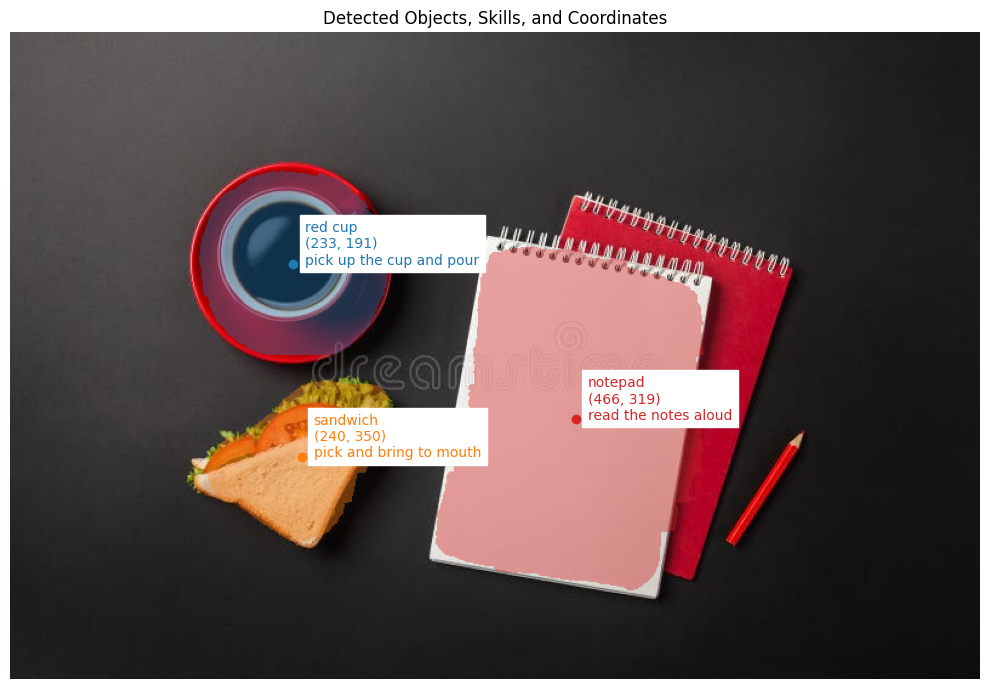

In [27]:
import matplotlib.patches as patches

# Generate distinct colors for each object
def get_colors(n):
    cmap = plt.get_cmap("tab10")
    return [cmap(i % 10) for i in range(n)]

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
colors = get_colors(len(objects))

for idx, obj in enumerate(objects):
    mask = segment_object(image, obj, threshold=tr)
    coords = get_center_coordinates(mask)
    skill = object_skills.get(obj, "inspect the object")

    # Show mask
    colored_mask = np.zeros((*mask.shape, 4))
    colored_mask[..., :3] = colors[idx][:3]  # RGB
    colored_mask[..., 3] = mask * 0.4  # Alpha
    ax.imshow(colored_mask)

    # Mark center and text with coordinates
    if coords:
        x, y = coords
        ax.plot(x, y, marker='o', color=colors[idx], markersize=6)
        ax.text(
            x + 10, y,
            f"{obj}\n({x}, {y})\n{skill}",
            fontsize=10, color=colors[idx], backgroundcolor='white'
        )

ax.axis('off')
plt.title("Detected Objects, Skills, and Coordinates")
plt.tight_layout()
plt.show()

## Task
Modify get_best_skill to return top-3 skills with similarity scores.

If top-1 similarity < 0.3, prompt the user with:

“I'm not confident. Did you mean one of these?”

Build a small function that handles this and ask them to simulate a human response.